In [73]:
import torch
import pdb
import random
import pandas as pd
from sklearn.model_selection import train_test_split
from transformers import RobertaTokenizer, RobertaModel, BertTokenizer, BertModel
import csv
import re
import tqdm
import multiprocessing
import pickle
import transformers
import numpy as np
import torch.nn as nn


In [ ]:
pip install transformers

     |████████████████████████████████| 1.8MB 7.6MB/s 
     |████████████████████████████████| 3.2MB 35.5MB/s 
     |████████████████████████████████| 890kB 62.0MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893261 sha256=b6e31bb0337bfb65c4770dc72f625ca174819bd70897c93b985b938fbbe32c74
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


In [ ]:
from google.colab import drive

drive.mount('/content/drive/')

Mounted at /content/drive/


In [74]:
import time
import datetime
#this is used to keep track of time during training
def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [117]:
train_df = pd.read_csv('drive/MyDrive/NLP_Coursework/ic_nlp_cw/task-1/train.csv')
test_df = pd.read_csv('drive/MyDrive/NLP_Coursework/ic_nlp_cw/task-1/dev.csv')
train_df

,id,original,edit,grades,meanGrade
0,14530,France is ‘ hunting down its citizens who join...,twins,10000,0.2
1,13034,"Pentagon claims 2,000 % increase in Russian tr...",bowling,33110,1.6
2,8731,Iceland PM Calls Snap Vote as Pedophile Furor ...,party,22100,1.0
3,76,"In an apparent first , Iran and Israel <engage...",slap,20000,0.4
4,6164,Trump was told weeks ago that Flynn misled <Vi...,school,0,0.0
...,...,...,...,...,...
9647,10899,State officials blast ' unprecedented ' DHS <m...,idea,0,0.0
9648,1781,Protesters Rally for <Refugees/> Detained at J...,stewardesses,20000,0.4
9649,5628,Cruise line Carnival Corp. joins the fight aga...,raisin,21000,0.6
9650,14483,Columbia police hunt woman seen with <gun/> ne...,cake,32200,1.4


In [118]:
#instead of having two inputs out of preprocessing, edit the dataset, and add in columns which we can use as inputs
#we can also add an 'old' field which contains the original word 
train_df['old'] = train_df.apply(lambda x:x['original'][x['original'].find('<')+1:x['original'].find('>')-1],axis=1)
test_df['old'] = test_df.apply(lambda x:x['original'][x['original'].find('<')+1:x['original'].find('>')-1],axis=1)

#first we add a field to the data which contains the edited headline
train_df['edited'] = train_df.apply(lambda x:x['original'].replace(x['original'][x['original'].find('<'):x['original'].find('>')+1],"??? " + x['edit'] ) ,axis=1)
test_df['edited'] = test_df.apply(lambda x:x['original'].replace(x['original'][x['original'].find('<'):x['original'].find('>')+1],"??? " + x['edit'] ) ,axis=1)

train_df['original'] = train_df.apply(lambda x:x['original'].replace(x['original'][x['original'].find('<'):x['original'].find('>')+1],"??? " 
                                                                     +x['old']) ,axis=1)
test_df['original'] = test_df.apply(lambda x:x['original'].replace(x['original'][x['original'].find('<'):x['original'].find('>')+1], "??? " +x['old']),axis=1)


In [119]:

#and then we can add another field which includes the sentence with old word + SEP + new word
#train_df['combined'] = train_df.apply(lambda x:x['edited'] + ' [SEP] From '+x['old'] + ' to '+x['edit'] ,axis=1)
#test_df['combined'] = test_df.apply(lambda x:x['edited'] + ' [SEP] From '+x['old'] + ' to '+x['edit'] ,axis=1)
train_df['combined'] = train_df.apply(lambda x:x['original'] + ' [SEP] ' + x['edited'] ,axis=1)
test_df['combined'] = test_df.apply(lambda x:x['original'] + ' [SEP]+ ' +x['edited'] ,axis=1)
train_df['combined'][5]

'All 22 ??? promises Trump made in his speech to Congress , in one chart [SEP] All 22 ??? sounds Trump made in his speech to Congress , in one chart'

In [120]:
from transformers import BertTokenizer
import torch

def tokenizer(data, column):
    # Load the BERT tokenizer.
    tokenizer = BertTokenizer.from_pretrained("bert-base-uncased",do_lower_case=True)

    # Get the lists of sentences and their labels  - using the finalized edited headline here
    sentences = data[column].values
    labels = data['meanGrade'].values

    input_ids = []
    attention_masks = []

    for sent in sentences:
        encoded_dict = tokenizer.encode_plus(
                            sent,                      # Sentence to encode.
                            #add_special_tokens = True, # this adds a CLS at the begining of a sentence and SEP at the end
                            max_length = 32,           # Pad & truncate all sentences.
                            pad_to_max_length = True,
                            return_attention_mask = True,   # Construct attn. masks for the padded tokens
                            return_tensors = 'pt',   # Return pytorch tensors.
                            #truncation = True
                       )

        # Add the encoded sentence to the list.    
        input_ids.append(encoded_dict['input_ids'])

        # And its attention mask (simply differentiates padding from non-padding).
        attention_masks.append(encoded_dict['attention_mask'])

    # Convert the lists into tensors.
    input_ids = torch.cat(input_ids, dim=0)
    attention_masks = torch.cat(attention_masks, dim=0)
    labels = torch.tensor(labels)
    
    return input_ids, attention_masks, labels

In [121]:
#we can decide which column of the dataset we want to train on - let's do the 'combined column'
#we can compare with the single sentence column later
train_ids, train_masks, train_labels = tokenizer(train_df, 'combined')
train_proportion = 0.8

/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:2155: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [122]:
from torch.utils.data import TensorDataset, random_split
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

#same as always
train_and_dev = TensorDataset(train_ids, train_masks, train_labels)

train_examples = round(len(train_and_dev)*train_proportion)
dev_examples = len(train_and_dev) - train_examples
train_dataset, dev_dataset = random_split(train_and_dev,
                                           (train_examples,
                                            dev_examples))


In [123]:
batch_size = 50

# Create the DataLoaders for our training and validation sets.
# We'll take training samples in random order (shuffle)
train_dataloader = DataLoader(
            train_dataset, 
            sampler = RandomSampler(train_dataset), 
            batch_size = batch_size
        )

validation_dataloader = DataLoader(
            dev_dataset, 
            sampler = SequentialSampler(dev_dataset), # Pull out batches sequentially.
            batch_size = batch_size 
        )

In [124]:
from transformers import BertForSequenceClassification, AdamW, BertConfig
 
#for regression, we can actually use for BertForSequenceClassifier and set the number of labels to 1
#which turns it into a regression problem

model = BertForSequenceClassification.from_pretrained(
    'bert-base-uncased', # the 12-layer BERT model, with an uncased vocab.
    num_labels = 1,  
    output_attentions = False, # don't return attention weights or hidden states
    output_hidden_states = False, 
)

model.cuda()
#store double values
model = model.double()

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [125]:
from transformers import get_linear_schedule_with_warmup

optimizer = AdamW(model.parameters(),
                  lr = 5e-3, 
                  eps = 1e-8 
                )

#BERT authors recommend between 2 and 4. 
epochs = 4

# Total number of training steps is [number of batches] x [number of epochs]. 
# not the same as the number of training samples).
total_steps = len(train_dataloader) * epochs

# The scheduler can actually learn the best learning rate throughout tranining
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, 
                                            num_training_steps = total_steps)

In [130]:
import random
from sklearn.metrics import mean_squared_error

# Set the seed value all over the place to make this reproducible.
random_seed = 42
random.seed(random_seed)
np.random.seed(random_seed)
torch.manual_seed(random_seed)
torch.cuda.manual_seed_all(random_seed)
torch.backends.cudnn.deterministic = True

use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")
device

training_stats = []

# Measure the total training time for the whole run.
total_t0 = time.time()

# For each epoch...
for epoch_i in range(0, epochs):
    
    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # Measure how long the training epoch takes.
    t0 = time.time()

    # Reset the total loss for this epoch.
    total_train_loss = 0

    model.train()

    for step, batch in enumerate(train_dataloader):

        # Progress update every 40 batches.
        if step % 40 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)
            
            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        model.zero_grad()        

        output = model(b_input_ids, 
                                    token_type_ids=None, 
                                    attention_mask=b_input_mask, 
                                    labels=b_labels)
        
        loss, predictions = output[:2]

        total_train_loss += loss.item()
        # Perform a backward pass to calculate the gradients.
        loss.backward()

        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        optimizer.step()

        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(train_dataloader)            
    
    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(training_time))
        
    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    print("")
    print("Running Validation...")

    t0 = time.time()

    # Put the model in evaluation mode--the dropout layers behave differently
    # during evaluation.
    model.eval()

    # Tracking variables 
    total_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0

    y_pred = np.array([])
    y_true = np.array([])

    # Evaluate data for one epoch
    for batch in validation_dataloader:
        
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        
        with torch.no_grad():        

          #this is a sequence classifier object which contains loss and predictions 
          output = model(b_input_ids, 
                                   token_type_ids=None, 
                                   attention_mask=b_input_mask,
                                   labels=b_labels) 
          loss, predictions = output[:2] 
 
        # Accumulate the validation loss.
        total_eval_loss += loss.item()


        # Move logits and labels to CPU
        predictions = predictions.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        y_pred = np.append(y_pred,predictions)
        y_true = np.append(y_true,label_ids)

    rmse = mean_squared_error(y_true, y_pred, squared=False)
    print("  RMSE: {0:.4f}".format(rmse))

    # Calculate the average loss over all of the batches.
    avg_val_loss = total_eval_loss / len(validation_dataloader)
    
    # Measure how long the validation run took.
    validation_time = format_time(time.time() - t0)
    
    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))

    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Valid. RMSE.': rmse,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )


print("")
print("Training complete!")

print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))


======== Epoch 1 / 3 ========
Training...
tensor(0.3914, device='cuda:0', dtype=torch.float64, grad_fn=<MseLossBackward>)
tensor(0.5338, device='cuda:0', dtype=torch.float64, grad_fn=<MseLossBackward>)
tensor(0.3816, device='cuda:0', dtype=torch.float64, grad_fn=<MseLossBackward>)
tensor(0.3888, device='cuda:0', dtype=torch.float64, grad_fn=<MseLossBackward>)
tensor(0.4091, device='cuda:0', dtype=torch.float64, grad_fn=<MseLossBackward>)
tensor(0.5856, device='cuda:0', dtype=torch.float64, grad_fn=<MseLossBackward>)
tensor(0.2646, device='cuda:0', dtype=torch.float64, grad_fn=<MseLossBackward>)
tensor(0.3608, device='cuda:0', dtype=torch.float64, grad_fn=<MseLossBackward>)
tensor(0.3351, device='cuda:0', dtype=torch.float64, grad_fn=<MseLossBackward>)
tensor(0.3771, device='cuda:0', dtype=torch.float64, grad_fn=<MseLossBackward>)
tensor(0.4120, device='cuda:0', dtype=torch.float64, grad_fn=<MseLossBackward>)
tensor(0.2519, device='cuda:0', dtype=torch.float64, grad_fn=<MseLossBackward

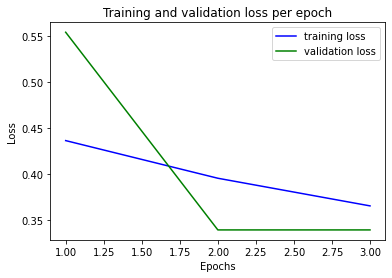

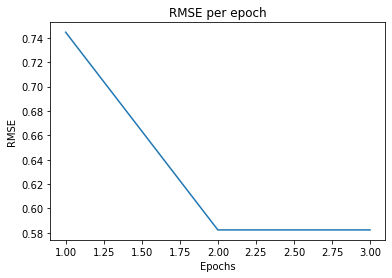

In [131]:

import matplotlib.pyplot as plt

epochs = []
training_loss = []
validation_loss = []
rmse = []

for e in training_stats:
  epochs.append(e['epoch'])
  training_loss.append(e['Training Loss'])
  validation_loss.append(e['Valid. Loss'])
  rmse.append(e['Valid. RMSE.'])

plt.plot(epochs, training_loss, color = 'blue', label = 'training loss')
plt.plot(epochs, validation_loss, color = 'green', label = 'validation loss')
plt.title("Training and validation loss per epoch")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

plt.plot(epochs, rmse)
plt.title("RMSE per epoch")
plt.xlabel("Epochs")
plt.ylabel("RMSE")
plt.show()



======== Epoch 1 / 4 ========
Training...
  Batch    40  of    242.    Elapsed: 0:01:36.
  Batch    80  of    242.    Elapsed: 0:03:13.
  Batch   120  of    242.    Elapsed: 0:04:49.
  Batch   160  of    242.    Elapsed: 0:06:25.
  Batch   200  of    242.    Elapsed: 0:08:02.
  Batch   240  of    242.    Elapsed: 0:09:38.

  Average training loss: 1.32
  Training epcoh took: 0:09:41

Running Validation...
  RMSE: 1.1461
  Validation Loss: 1.32
  Validation took: 0:00:49

======== Epoch 2 / 4 ========
Training...
  Batch    40  of    242.    Elapsed: 0:01:36.
  Batch    80  of    242.    Elapsed: 0:03:12.
  Batch   120  of    242.    Elapsed: 0:04:49.
  Batch   160  of    242.    Elapsed: 0:06:25.
  Batch   200  of    242.    Elapsed: 0:08:02.
  Batch   240  of    242.    Elapsed: 0:09:38.

  Average training loss: 1.32
  Training epcoh took: 0:09:41

Running Validation...
  RMSE: 1.1461
  Validation Loss: 1.32
  Validation took: 0:00:49

======== Epoch 3 / 4 ========
Training...
  Bat